### Predicting wood, charcoal, and other solid fuels for cooking in Mexican households

Currently, 13% of homes in Mexico cook with wood or charcoal as their primary fuel source, with 39% of homes in the four poorest states doing so. And despite being in the top 5 of GDP per capita in Latin America, Mexico trails most of the South and Central American countries in access to clean cooking fuels. What can we learn about areas in Mexico that have high use of wood or charcoal cooking that could predict which homes use wood or charcoal as their primary cooking fuel and why they haven't switched to gas or electric? Is it cultural? Economic? Something else? This is an important question as there are major health, climate, and deforestation implications for continuing to cook with biofuels.

### Understanding the Implications

Cooking with wood and charcoal has several important socioeconomic impacts on populations. First, cooking by burning solid fuels is a health hazard due to inhalation of smoke. This is a particularly acute issue for women's health. Second, the use of burning wood and charcoal can lead to deforestation, incease CO2 in the atomosphere, and increase particulate pollution locally. As the world, and Mexico, increases development and switches from solid biofuels to gas or electric cooking appliances, there is value in understanding what households use biomass cooking today, what are the main reasons those households do, and how can government incentives, utilities, and appliance companies increase utilization of other forms of cooking fuel. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import geopandas as gpd
from sklearn.ensemble import VotingRegressor, BaggingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

### Understanding the Data

This data comes from IPUMS International Mexico Census Data 2020. I have selected a data extract for 1% of population size or 1.5M individuals. This data includes household information (e.g., utilities, house size, ownership), as well as geographical information and personal demographics of individuals in the house.

In [4]:
raw_data = pd.read_csv('Data/ipumsi_00003.csv.gz')

In [6]:
raw_data.describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
COUNTRY,1500909.0,4.840000e+02,0.000000e+00,4.840000e+02,4.840000e+02,4.840000e+02,4.840000e+02,4.840000e+02
YEAR,1500909.0,2.020000e+03,0.000000e+00,2.020000e+03,2.020000e+03,2.020000e+03,2.020000e+03,2.020000e+03
SAMPLE,1500909.0,4.842020e+08,0.000000e+00,4.842020e+08,4.842020e+08,4.842020e+08,4.842020e+08,4.842020e+08
SERIAL,1500909.0,1.981807e+09,1.159707e+09,6.000000e+03,9.690560e+08,1.968785e+09,2.968215e+09,4.016625e+09
PERSONS,1500909.0,4.823164e+00,2.339127e+00,1.000000e+00,3.000000e+00,4.000000e+00,6.000000e+00,2.900000e+01
HHWT,1500909.0,8.354003e+01,1.401998e+02,9.990000e+00,9.990000e+00,3.996000e+01,7.992000e+01,6.763230e+03
POPDENSGEO1,1500909.0,2.650132e+02,8.276464e+02,1.096000e+01,4.493000e+01,8.043000e+01,1.914200e+02,6.128350e+03
GEO1_MX,1500909.0,4.840181e+05,7.798928e+00,4.840010e+05,4.840120e+05,4.840180e+05,4.840230e+05,4.840320e+05
GEO2_MX,1500909.0,4.840181e+08,7.816861e+03,4.840010e+08,4.840121e+08,4.840180e+08,4.840230e+08,4.840321e+08
LOCALMX,1500909.0,8.754076e+03,2.999288e+03,1.010000e+02,9.999000e+03,9.999000e+03,9.999000e+03,9.999000e+03


In [8]:
#we don't need Country, Year, or Sample since this dataset is all Mexico, 2020, and all part of the same IPUMS sample
data = raw_data.drop(columns = ['COUNTRY', 'YEAR', 'SAMPLE'])

In [10]:
data.head()

,SERIAL,PERSONS,HHWT,POPDENSGEO1,GEO1_MX,GEO2_MX,LOCALMX,OWNERSHIP,OWNERSHIPD,ELECTRIC,...,KITCHEN,HHTYPE,NFAMS,PERNUM,PERWT,AGE,SEX,SPEAKIND,LIT,INCEARN
0,6000,4,589.41,253.08,484001,484001001,101,1,100,1,...,21,3,1,1,589.41,40,1,4,2,25000
1,6000,4,589.41,253.08,484001,484001001,101,1,100,1,...,21,3,1,2,589.41,41,2,4,2,25000
2,6000,4,589.41,253.08,484001,484001001,101,1,100,1,...,21,3,1,3,589.41,10,2,4,2,99999999
3,6000,4,589.41,253.08,484001,484001001,101,1,100,1,...,21,3,1,4,589.41,7,2,4,2,99999999
4,16000,5,589.41,253.08,484001,484001001,101,1,100,1,...,21,6,1,1,589.41,39,2,4,2,26000


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500909 entries, 0 to 1500908
Data columns (total 28 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   SERIAL       1500909 non-null  int64  
 1   PERSONS      1500909 non-null  int64  
 2   HHWT         1500909 non-null  float64
 3   POPDENSGEO1  1500909 non-null  float64
 4   GEO1_MX      1500909 non-null  int64  
 5   GEO2_MX      1500909 non-null  int64  
 6   LOCALMX      1500909 non-null  int64  
 7   OWNERSHIP    1500909 non-null  int64  
 8   OWNERSHIPD   1500909 non-null  int64  
 9   ELECTRIC     1500909 non-null  int64  
 10  WATSUP       1500909 non-null  int64  
 11  SEWAGE       1500909 non-null  int64  
 12  FUELCOOK     1500909 non-null  int64  
 13  PHONE        1500909 non-null  int64  
 14  CELL         1500909 non-null  int64  
 15  INTERNET     1500909 non-null  int64  
 16  TRASH        1500909 non-null  int64  
 17  ROOMS        1500909 non-null  int64  
 18  KI

In [14]:
#list categorical columns
categorical_raw = ['GEO1_MX', 'GEO2_MX', 'LOCALMX', 'OWNERSHIP','OWNERSHIPD','ELECTRIC','WATSUP','SEWAGE','FUELCOOK','PHONE','CELL',
                   'INTERNET', 'TRASH','KITCHEN','HHTYPE','SEX','SPEAKIND','LIT']

In [16]:
for col in data:
    if col in categorical_raw:
        data[col] = data[col].astype('category')

In [18]:
data.head()

,SERIAL,PERSONS,HHWT,POPDENSGEO1,GEO1_MX,GEO2_MX,LOCALMX,OWNERSHIP,OWNERSHIPD,ELECTRIC,...,KITCHEN,HHTYPE,NFAMS,PERNUM,PERWT,AGE,SEX,SPEAKIND,LIT,INCEARN
0,6000,4,589.41,253.08,484001,484001001,101,1,100,1,...,21,3,1,1,589.41,40,1,4,2,25000
1,6000,4,589.41,253.08,484001,484001001,101,1,100,1,...,21,3,1,2,589.41,41,2,4,2,25000
2,6000,4,589.41,253.08,484001,484001001,101,1,100,1,...,21,3,1,3,589.41,10,2,4,2,99999999
3,6000,4,589.41,253.08,484001,484001001,101,1,100,1,...,21,3,1,4,589.41,7,2,4,2,99999999
4,16000,5,589.41,253.08,484001,484001001,101,1,100,1,...,21,6,1,1,589.41,39,2,4,2,26000


### Data Preparation

Now that I know what's in the data and how IPUMS exports their extracts, I can begin to make the data more useable for modeling, as well as more interpretable. This will mean converting numeric codes to geographic locations at the state level, mapping categorical variables to their census collected responses, reducing the different options to reduce dimensionality in the data, and finally aggregating the data by household, rather than by individual.

In [21]:
data_category = data

#convert numeric codes to categorical variables
#because I want to keep mapping regions as numbers to match to mapping data, need both columns
state_mapping = {
        484001: "Aguascalientes", 484002: "Baja California", 484003: "Baja California Sur",
        484004: "Campeche", 484005: "Coahuila de Zaragoza", 484006: "Colima", 484007: "Chiapas",
        484008: "Chihuahua", 484009: "Distrito Federal", 484010: "Durango", 484011: "Guanajuato",
        484012: "Guerrero", 484013: "Hidalgo", 484014: "Jalisco", 484015: "México",
        484016: "Michoacán de Ocampo", 484017: "Morelos", 484018: "Nayarit", 484019: "Nuevo León",
        484020: "Oaxaca", 484021: "Puebla", 484022: "Querétaro", 484023: "Quintana Roo",
        484024: "San Luis Potosí", 484025: "Sinaloa", 484026: "Sonora", 484027: "Tabasco",
        484028: "Tamaulipas", 484029: "Tlaxcala", 484030: "Veracruz de Ignacio de la Llave",
        484031: "Yucatán", 484032: "Zacatecas"
}
data_category['STATE_NAME'] = data['GEO1_MX'].map(state_mapping)

#the rest of the easy to map categorical columns can be mapped here
other_category_mappings = {
    "OWNERSHIP": {0: "NIU", 1: "Owned", 2: "Not owned", 9: "Unknown"},
    "ELECTRIC": {0: "NIU", 1: "Yes", 2: "No", 9: "Unknown"},
    "PHONE": {0: "NIU", 1: "No", 2: "Yes", 9: "Unknown"},
    "CELL": {0: "NIU", 1: "Yes", 2: "No", 9: "Unknown"},
    "INTERNET": {0: "NIU", 1: "No", 2: "Yes", 9: "Unknown"},
    "SEX": {1: "Male", 2: "Female", 9: "Unknown"},
    "HHTYPE": {0: "Vacant household", 1: "One-person household", 2: "Married/cohab couple, no children", 
               3: "Married/cohab couple with children", 4: "Single-parent family", 5: "Polygamous family", 
               6: "Extended family, relatives only", 7: "Composite household, family and non-relatives", 8: "Non-family household", 
               9: "Unclassified subfamily", 10: "Other relative or non-relative household", 11: "Group quarters", 99: "Unclassifiable"},
    "LIT": {0: "NIU", 1: "No, illiterate", 2: "Yes, literate", 9: "Unknown"},
    "SEWAGE": {00: "NIU", 10: "Connected to sewage system or septic", 11:"Sewage system", 12: "Septic tank", 20: "Not connected", 99: "Unknown"},
    "SPEAKIND": {0: "NIU", 1: "Yes", 2: "Yes", 3: "Yes", 4: "No", 8: "Does not speak", 9: "Unknown"}
}

# Apply mappings to categorical columns
for col, mapping in other_category_mappings.items():
    if col in data.columns:
        data_category[col] = data[col].map(mapping)

#there are other harder to map categorical columns that must be simplified
def map_water_type(value):
    if value in [00]:
        return 'NIU'
    elif value in [10,11,12,13]:
        return 'Piped, in home'
    elif value in [14,15,16,17,18]:
        return 'Piped access'
    elif value in [20]:
        return 'No piped access'
    else:
        return 'Unknown'

data_category['WATSUP'] = data['WATSUP'].apply(map_water_type)

def map_trash_type(value):
    if value in [00]:
        return 'NIU'
    elif value in [10, 11,12,13,14]:
        return 'Collected'
    elif value in [20,21,22,23,24,25,26,27,28,29,30,31,32,33,34]:
        return 'Burned, burried, or dumped'
    elif value in [35,36,37,38]:
        return 'Fed to animals, composted, or heaped'
    elif value in [39]:
        return 'Other'
    else:
        return 'Unknown'

data_category['TRASH'] = data['TRASH'].apply(map_trash_type)

def map_kitchen_type(value):
    if value in [00]:
        return 'NIU'
    elif value in [10,11,13]:
        return 'No kitchen'
    elif value in [20,21,22,23,24,25]:
        return 'Indoor kitchen'
    elif value in [26,27,28]:
        return 'Outdoor kitchen'
    else:
        return 'Unknown'

data_category['KITCHEN'] = data['KITCHEN'].apply(map_kitchen_type)

def map_fuel_type(value):
    if value in [00]:
        return 'NIU'
    elif value in [10]:
        return 'None'
    elif value in [20]:
        return 'Electric'
    elif value in [30,31,32,33,34,35]:
        return 'Petroleum gas (NG, propane, or other)'
    elif value in [40,41,42,43,44,45,46,47]:
        return 'Petroleum liquid (gasoline, diesel, keorsene)'
    elif value in [50,51,52,53,54,55,56,73,74,75]:
        return 'Wood, charcoal, coal, or other burned biomaterial'
    elif value in [70,71,72,76,77]:
        return 'Other (solar, alcohol, etc.)'
    else:
        return 'Unknown'

data_category['FUELCOOK'] = data['FUELCOOK'].apply(map_fuel_type)

data_category.head(30)

,SERIAL,PERSONS,HHWT,POPDENSGEO1,GEO1_MX,GEO2_MX,LOCALMX,OWNERSHIP,OWNERSHIPD,ELECTRIC,...,HHTYPE,NFAMS,PERNUM,PERWT,AGE,SEX,SPEAKIND,LIT,INCEARN,STATE_NAME
0,6000,4,589.41,253.08,484001,484001001,101,Owned,100,Yes,...,Married/cohab couple with children,1,1,589.41,40,Male,No,"Yes, literate",25000,Aguascalientes
1,6000,4,589.41,253.08,484001,484001001,101,Owned,100,Yes,...,Married/cohab couple with children,1,2,589.41,41,Female,No,"Yes, literate",25000,Aguascalientes
2,6000,4,589.41,253.08,484001,484001001,101,Owned,100,Yes,...,Married/cohab couple with children,1,3,589.41,10,Female,No,"Yes, literate",99999999,Aguascalientes
3,6000,4,589.41,253.08,484001,484001001,101,Owned,100,Yes,...,Married/cohab couple with children,1,4,589.41,7,Female,No,"Yes, literate",99999999,Aguascalientes
4,16000,5,589.41,253.08,484001,484001001,101,Owned,100,Yes,...,"Extended family, relatives only",1,1,589.41,39,Female,No,"Yes, literate",26000,Aguascalientes
5,16000,5,589.41,253.08,484001,484001001,101,Owned,100,Yes,...,"Extended family, relatives only",1,2,589.41,82,Male,No,"Yes, literate",99999999,Aguascalientes
6,16000,5,589.41,253.08,484001,484001001,101,Owned,100,Yes,...,"Extended family, relatives only",1,3,589.41,72,Female,No,"Yes, literate",99999999,Aguascalientes
7,16000,5,589.41,253.08,484001,484001001,101,Owned,100,Yes,...,"Extended family, relatives only",1,4,589.41,10,Female,No,"Yes, literate",99999999,Aguascalientes
8,16000,5,589.41,253.08,484001,484001001,101,Owned,100,Yes,...,"Extended family, relatives only",1,5,589.41,17,Male,No,"Yes, literate",99999999,Aguascalientes
9,26000,4,589.41,253.08,484001,484001001,101,Owned,100,Yes,...,Married/cohab couple with children,1,1,589.41,23,Male,No,"Yes, literate",10750,Aguascalientes


In [23]:
data_category.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
SERIAL,1500909.0,NaN,NaN,NaN,1981807478.641943,1159707041.20291,6000.0,969056000.0,1968785000.0,2968215000.0,4016625000.0
PERSONS,1500909.0,NaN,NaN,NaN,4.823164,2.339127,1.0,3.0,4.0,6.0,29.0
HHWT,1500909.0,NaN,NaN,NaN,83.540027,140.199763,9.99,9.99,39.96,79.92,6763.23
POPDENSGEO1,1500909.0,NaN,NaN,NaN,265.013182,827.646435,10.96,44.93,80.43,191.42,6128.35
GEO1_MX,1500909.0,32.0,484020.0,194246.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GEO2_MX,1500909.0,2325.0,484009001.0,16285.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LOCALMX,1500909.0,233.0,9999.0,1278429.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OWNERSHIP,1500909,4,Owned,1176854,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OWNERSHIPD,1500909.0,6.0,100.0,1176854.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ELECTRIC,1500909,4,Yes,1471215,NaN,NaN,NaN,NaN,NaN,NaN,NaN


I now have all the data categorized how I want it to be and can see we have our categorical variables renamed. First flag here is that over 50% of the earned income values are not found or are unknown which may prove difficult for the analysis.

In [26]:
#to make everything more readable, relabel all columns
data_category = data_category.rename(columns = {
    'OWNERSHIPD': 'DETAILEDOWNERSHIP',
    'WATSUP': 'WATERSUPPLY',
    'FUELCOOK': 'COOKINGFUEL',
    'ROOMS': 'NUMROOMS',
    'NFAMS': 'NUMFAMILIES',
    'BPLCOUNTRY': 'BIRTHCOUNTRY',
    'LIT': 'LITERACY',
    'INCEARN': 'EARNEDINCOME'
})

In [28]:
data_category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500909 entries, 0 to 1500908
Data columns (total 29 columns):
 #   Column             Non-Null Count    Dtype   
---  ------             --------------    -----   
 0   SERIAL             1500909 non-null  int64   
 1   PERSONS            1500909 non-null  int64   
 2   HHWT               1500909 non-null  float64 
 3   POPDENSGEO1        1500909 non-null  float64 
 4   GEO1_MX            1500909 non-null  category
 5   GEO2_MX            1500909 non-null  category
 6   LOCALMX            1500909 non-null  category
 7   OWNERSHIP          1500909 non-null  category
 8   DETAILEDOWNERSHIP  1500909 non-null  category
 9   ELECTRIC           1500909 non-null  category
 10  WATERSUPPLY        1500909 non-null  category
 11  SEWAGE             1500909 non-null  category
 12  COOKINGFUEL        1500909 non-null  category
 13  PHONE              1500909 non-null  category
 14  CELL               1500909 non-null  category
 15  INTERNET       

In [30]:
#first look at the data to understand where there are unknowns and NIU
for feature in data_category.columns:
    print(data_category[feature].value_counts(normalize = True))

SERIAL
1384560000    1.932162e-05
910225000     1.865536e-05
1919704000    1.798910e-05
2400094000    1.798910e-05
3030193000    1.665657e-05
                  ...     
3500292000    6.662629e-07
1120554000    6.662629e-07
1120584000    6.662629e-07
1120594000    6.662629e-07
1693341000    6.662629e-07
Name: proportion, Length: 402065, dtype: float64
PERSONS
4     0.222732
5     0.192760
3     0.152448
6     0.120831
2     0.098384
7     0.072248
8     0.042598
1     0.031416
9     0.025203
10    0.016004
11    0.009300
12    0.006172
13    0.003534
14    0.002257
15    0.001399
16    0.000800
17    0.000680
18    0.000360
19    0.000228
20    0.000173
21    0.000154
22    0.000088
23    0.000061
25    0.000050
24    0.000048
27    0.000036
29    0.000019
28    0.000019
Name: proportion, dtype: float64
HHWT
9.99       2.634257e-01
29.97      1.243340e-01
39.96      1.061403e-01
19.98      1.057992e-01
49.95      6.826463e-02
               ...     
2247.75    1.332526e-06
3896.10    6.

At first look, it appears NIU and Unknowns are very small, which is good - these values can be eliminated from the dataset where they exist. The next step is to aggregate the data by household - this means finding total household income and keeping household information. <br>
<br>
It also appears that there may be some overweighting for location (e.g., Oaxaca is overrepresented in this dataset and Mexico state population is not the highest). There are also some features that do not give much information that can be eliminated, such as Locality.<br>
<br>
However, it appears income is unknown for 63% of individuals in the dataset, I will likely need to eliminate these populations unless there are other demographics that are key in determining wood fuel use.

In [33]:
#Create new dataset that is just households. Need to find total household income, keep variables like size, location, etc.
#variables that will change with household roll-up: age, person weight, age, sex, language, Literacy, Income

#first remove the columns we don't need for household roll-up or first pass regression
data_household_raw = data_category.drop(columns = ['PERWT','LOCALMX','DETAILEDOWNERSHIP','POPDENSGEO1','PERNUM','GEO1_MX'])

In [35]:
#double check which numbers are consistent across households by sampling random households
data_household_raw[data_household_raw['SERIAL'] == 6000].T

,0,1,2,3
SERIAL,6000,6000,6000,6000
PERSONS,4,4,4,4
HHWT,589.41,589.41,589.41,589.41
GEO2_MX,484001001,484001001,484001001,484001001
OWNERSHIP,Owned,Owned,Owned,Owned
ELECTRIC,Yes,Yes,Yes,Yes
WATERSUPPLY,"Piped, in home","Piped, in home","Piped, in home","Piped, in home"
SEWAGE,Sewage system,Sewage system,Sewage system,Sewage system
COOKINGFUEL,"Petroleum gas (NG, propane, or other)","Petroleum gas (NG, propane, or other)","Petroleum gas (NG, propane, or other)","Petroleum gas (NG, propane, or other)"
PHONE,Yes,Yes,Yes,Yes


Given that everything remains consistent ex;cept Age, sex, language spoken, literacy, and income, I will take the first value of each household for all properties, and then aggregate the remaining values (e.g., how many M and F in each household, total income, if someone speaks an indigineous language, # of children)

In [38]:
#create the aggregation rules for the groupby function
agg_rules = {
    'PERSONS': 'first',
    'HHWT': 'first',
    'GEO2_MX': 'first',
    'OWNERSHIP': 'first',
    'ELECTRIC': 'first',
    'WATERSUPPLY': 'first',
    'SEWAGE': 'first',
    'COOKINGFUEL': 'first',
    'PHONE': 'first',
    'CELL': 'first',
    'INTERNET': 'first',
    'TRASH': 'first',
    'NUMROOMS': 'first',
    'KITCHEN': 'first',
    'HHTYPE': 'first',
    'NUMFAMILIES': 'first',
    'AGE': [
        ('CHILDREN', lambda x: (x < 18).sum()),
        ('OLDER_ADULTS', lambda x: (x >= 60).sum())
    ],
    'SEX': [
        ('MALE_COUNT', lambda x: (x == 'Male').sum()),
        ('FEMALE_COUNT', lambda x: (x == 'Female').sum())
    ],
    'SPEAKIND': lambda x: 1 if (x == 'Yes').any() else 0,
    'LITERACY': lambda x: 1 if (x == 'No, illiterate').any() else 0,
    'EARNEDINCOME': lambda x: 'Unknown' if (x == 99999998).all() else x[x < 99999998].sum(),
    'STATE_NAME': 'first'
}

In [40]:
data_HH = data_household_raw.groupby('SERIAL').agg(agg_rules).reset_index()

In [42]:
data_HH

SERIAL PERSONS    HHWT    GEO2_MX  OWNERSHIP ELECTRIC  \
                     first   first      first      first    first   
0             6000       4  589.41  484001001      Owned      Yes   
1            16000       5  589.41  484001001      Owned      Yes   
2            26000       4  589.41  484001001      Owned      Yes   
3            36000       5  589.41  484001001      Owned      Yes   
4            46000       5  589.41  484001001  Not owned      Yes   
...            ...     ...     ...        ...        ...      ...   
402060  4016585000       2    9.99  484032004      Owned      Yes   
402061  4016595000       1    9.99  484032004      Owned      Yes   
402062  4016605000       3    9.99  484032004  Not owned      Yes   
402063  4016615000       2    9.99  484032004      Owned      Yes   
402064  4016625000       2    9.99  484032004      Owned      Yes   

            WATERSUPPLY         SEWAGE  \
                  first          first   
0        Piped, in home  Sewage system   
1        Piped, in home  Sewage system   
2        Piped, in home  Sewage system   
3        Piped, in home  Sewage system   
4        Piped, in home  Sewage system   
...                 ...            ...   
402060   Piped, in home  Not connected   
402061   Piped, in home    Septic tank   
402062     Piped access    Septic tank   
402063     Piped access    Septic tank   
402064  No piped access  Not connected   

                                              COOKINGFUEL PHONE  ...  \
                                                    first first  ...   
0                   Petroleum gas (NG, propane, or other)   Yes  ...   
1                   Petroleum gas (NG, propane, or other)   Yes  ...   
2                   Petroleum gas (NG, propane, or other)    No  ...   
3                   Petroleum gas (NG, propane, or other)    No  ...   
4                   Petroleum gas (NG, propane, or other)    No  ...   
...                                                   ...   ...  ...   
402060              Petroleum gas (NG, propane, or other)    No  ...   
402061  Wood, charcoal, coal, or other burned biomaterial    No  ...   
402062              Petroleum gas (NG, propane, or other)    No  ...   
402063  Wood, charcoal, coal, or other burned biomaterial    No  ...   
402064  Wood, charcoal, coal, or other burned biomaterial    No  ...   

                                    HHTYPE NUMFAMILIES      AGE               \
                                     first       first CHILDREN OLDER_ADULTS   
0       Married/cohab couple with children           1        2            0   
1          Extended family, relatives only           1        2            2   
2       Married/cohab couple with children           1        2            0   
3       Married/cohab couple with children           1        3            0   
4       Married/cohab couple with children           1        3            0   
...                                    ...         ...      ...          ...   
402060   Married/cohab couple, no children           1        0            2   
402061                One-person household           1        0            1   
402062  Married/cohab couple with children           1        1            0   
402063   Married/cohab couple, no children           1        0            2   
402064   Married/cohab couple, no children           1        0            0   

              SEX              SPEAKIND LITERACY EARNEDINCOME      STATE_NAME  
       MALE_COUNT FEMALE_COUNT <lambda> <lambda>     <lambda>           first  
0               1            3        0        0        50000  Aguascalientes  
1               2            3        0        0        26000  Aguascalientes  
2               3            1        0        0        10750  Aguascalientes  
3               2            3        0        1        14160  Aguascalientes  
4               2            3        0        1        13760  Aguascalientes  
...           ...          ..

In [44]:
#remove the second order column names
data_HH.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in data_HH.columns]

In [46]:
data_HH = data_HH.rename(columns = {
    'PERSONS_first': 'PERSONS',
    'HHWT_first': 'HHWT',
    'NUMROOMS_first': 'NUMROOMS',
    'GEO2_MX_first': 'GEO2_MX',
    'OWNERSHIP_first': 'OWNERSHIP',
    'WATERSUPPLY_first': 'WATERSUPPLY',
    'SEWAGE_first': 'SEWAGE',
    'COOKINGFUEL_first': 'COOKINGFUEL',
    'ELECTRIC_first': 'ELECTRIC',
    'PHONE_first': 'PHONE',
    'CELL_first': 'CELL',
    'INTERNET_first': 'INTERNET',
    'TRASH_first': 'TRASH',
    'KITCHEN_first': 'KITCHEN',
    'NUMFAMILIES_first': 'NUMFAMILIES',
    'HHTYPE_first': 'HHTYPE',
    'AGE_CHILDREN': 'CHILDREN',
    'AGE_OLDER_ADULTS': 'OLDER_ADULTS',
    'SEX_MALE_COUNT': 'MALE_COUNT',
    'SEX_FEMALE_COUNT': 'FEMALE_COUNT',
    'SPEAKIND_<lambda>': 'SPEAKIND',
    'LITERACY_<lambda>': 'ANY ILLITERACY',
    'EARNEDINCOME_<lambda>': 'HHINCOME',
    'STATE_NAME_first': 'STATE_NAME'
})

In [48]:
data_HH.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
SERIAL,402065.0,NaN,NaN,NaN,2008315675.015234,1159502460.150636,6000.0,1004161000.0,2008316000.0,3012471000.0,4016625000.0
PERSONS,402065.0,NaN,NaN,NaN,3.733001,2.017323,1.0,2.0,4.0,5.0,29.0
HHWT,402065.0,NaN,NaN,NaN,87.005566,144.127524,9.99,19.98,39.96,79.92,6763.23
GEO2_MX,402065.0,2325.0,484009001.0,5122.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OWNERSHIP,402065,4,Owned,305872,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ELECTRIC,402065,4,Yes,393274,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WATERSUPPLY,402065,5,"Piped, in home",229679,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SEWAGE,402065,5,Sewage system,233756,NaN,NaN,NaN,NaN,NaN,NaN,NaN
COOKINGFUEL,402065,7,"Petroleum gas (NG, propane, or other)",255720,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PHONE,402065,4,No,310559,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now there are 400K households of data from 15M people, but there is still cleaning that needs to happpen with numerical data. For example, NUMROOMS values of 99 mean 'unknown'. There's also something to be looked at with income since there were so many Unknown and 0 values.

In [51]:
#relabel NUMROOMS >97 to unknown
data_HH['NUMROOMS'] = data_HH['NUMROOMS'].apply(lambda x: 'Unknown' if x > 97 else x)

In [53]:
data_HH[data_HH['HHINCOME']=='Unknown']['HHINCOME'].value_counts()

HHINCOME
Unknown    144
Name: count, dtype: int64

In [54]:
#can now remove the Unknowns and NIU since they are both <0.5% of data in all categories
data_HH_clean = data_HH.replace(['NIU', 'Unknown'], np.nan)
data_HH_clean = data_HH_clean.dropna()
data_HH_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 399847 entries, 0 to 402064
Data columns (total 25 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   SERIAL          399847 non-null  int64   
 1   PERSONS         399847 non-null  int64   
 2   HHWT            399847 non-null  float64 
 3   GEO2_MX         399847 non-null  category
 4   OWNERSHIP       399847 non-null  category
 5   ELECTRIC        399847 non-null  category
 6   WATERSUPPLY     399847 non-null  category
 7   SEWAGE          399847 non-null  category
 8   COOKINGFUEL     399847 non-null  category
 9   PHONE           399847 non-null  category
 10  CELL            399847 non-null  category
 11  INTERNET        399847 non-null  category
 12  TRASH           399847 non-null  object  
 13  NUMROOMS        399847 non-null  float64 
 14  KITCHEN         399847 non-null  category
 15  HHTYPE          399847 non-null  category
 16  NUMFAMILIES     399847 non-null  int64   
 

Lost 2,000 houses or 0.5% of the data

In [58]:
for feature in ['OWNERSHIP','ELECTRIC','WATERSUPPLY','SEWAGE','COOKINGFUEL','PHONE','CELL','INTERNET','TRASH','NUMROOMS',
                'KITCHEN','HHTYPE','SPEAKIND','HHINCOME','ANY ILLITERACY','CHILDREN','OLDER_ADULTS','MALE_COUNT','FEMALE_COUNT']:
    print(data_HH_clean[feature].value_counts())

OWNERSHIP
Owned        305327
Not owned     94520
Name: count, dtype: int64
ELECTRIC
Yes    392428
No       7419
Name: count, dtype: int64
WATERSUPPLY
Piped, in home     229200
Piped access       142499
No piped access     28148
Name: count, dtype: int64
SEWAGE
Sewage system    233245
Septic tank      108665
Not connected     57937
Name: count, dtype: int64
COOKINGFUEL
Petroleum gas (NG, propane, or other)                255310
Wood, charcoal, coal, or other burned biomaterial    134113
None                                                   7346
Electric                                               3022
Other (solar, alcohol, etc.)                             56
Name: count, dtype: int64
PHONE
No     309872
Yes     89975
Name: count, dtype: int64
CELL
Yes    309192
No      90655
Name: count, dtype: int64
INTERNET
No     265092
Yes    134755
Name: count, dtype: int64
TRASH
Collected                     290372
Burned, burried, or dumped    109475
Name: count, dtype: int64
NUMROOMS
3.0  

Now that I have the data I want to make cuts on, I also want to separate out cooking fuels to be either wood/charcoal/coal or other cooking fuels so that I can decide if I want to do predictive modeling on all types of fuel or on just wood and biomass vs. not.

In [61]:
data_HH_clean['WOOD_CHARCOAL_FUEL'] = data_HH_clean['COOKINGFUEL'].isin(['Wood, charcoal, coal, or other burned biomaterial']).astype(int)
data_HH_clean

,SERIAL,PERSONS,HHWT,GEO2_MX,OWNERSHIP,ELECTRIC,WATERSUPPLY,SEWAGE,COOKINGFUEL,PHONE,...,NUMFAMILIES,CHILDREN,OLDER_ADULTS,MALE_COUNT,FEMALE_COUNT,SPEAKIND,ANY ILLITERACY,HHINCOME,STATE_NAME,WOOD_CHARCOAL_FUEL
0,6000,4,589.41,484001001,Owned,Yes,"Piped, in home",Sewage system,"Petroleum gas (NG, propane, or other)",Yes,...,1,2,0,1,3,0,0,50000.0,Aguascalientes,0
1,16000,5,589.41,484001001,Owned,Yes,"Piped, in home",Sewage system,"Petroleum gas (NG, propane, or other)",Yes,...,1,2,2,2,3,0,0,26000.0,Aguascalientes,0
2,26000,4,589.41,484001001,Owned,Yes,"Piped, in home",Sewage system,"Petroleum gas (NG, propane, or other)",No,...,1,2,0,3,1,0,0,10750.0,Aguascalientes,0
3,36000,5,589.41,484001001,Owned,Yes,"Piped, in home",Sewage system,"Petroleum gas (NG, propane, or other)",No,...,1,3,0,2,3,0,1,14160.0,Aguascalientes,0
4,46000,5,589.41,484001001,Not owned,Yes,"Piped, in home",Sewage system,"Petroleum gas (NG, propane, or other)",No,...,1,3,0,2,3,0,1,13760.0,Aguascalientes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402060,4016585000,2,9.99,484032004,Owned,Yes,"Piped, in home",Not connected,"Petroleum gas (NG, propane, or other)",No,...,1,0,2,1,1,0,0,0.0,Zacatecas,0
402061,4016595000,1,9.99,484032004,Owned,Yes,"Piped, in home",Septic tank,"Wood, charcoal, coal, or other burned biomaterial",No,...,1,0,1,1,0,0,0,0.0,Zacatecas,1
402062,4016605000,3,9.99,484032004,Not owned,Yes,Piped access,Septic tank,"Petroleum gas (NG, propane, or other)",No,...,1,1,0,2,1,0,0,5160.0,Zacatecas,0
402063,4016615000,2,9.99,484032004,Owned,Yes,Piped access,Septic tank,"Wood, charcoal, coal, or other burned biomaterial",No,...,1,0,2,1,1,0,0,0.0,Zacatecas,1


In [63]:
#determine proportion of households by state that use wood as primary means of cooking fuel
#this is a benchmark to ensure the data is fairly representative
wood_fuel_by_state = (
    data_HH_clean.groupby('STATE_NAME')
    .apply(lambda x: (x['WOOD_CHARCOAL_FUEL'] * x['HHWT']).sum() / x['HHWT'].sum())
    .reset_index(name = 'PERCENT_WOOD_FUEL').sort_values(by='PERCENT_WOOD_FUEL',ascending=False)
)
wood_fuel_by_state

,STATE_NAME,PERCENT_WOOD_FUEL
6,Chiapas,0.496304
19,Oaxaca,0.456776
11,Guerrero,0.411100
30,Yucatán,0.278292
26,Tabasco,0.271278
29,Veracruz de Ignacio de la Llave,0.251600
3,Campeche,0.238150
20,Puebla,0.212803
23,San Luis Potosí,0.198049
12,Hidalgo,0.192594


50% of households in Chiapas and Oaxaca use wood burning stoves, so I'm assuming states, and local jurisdictions, will have a large impact on whether a house has wood as the primary cooking fuel

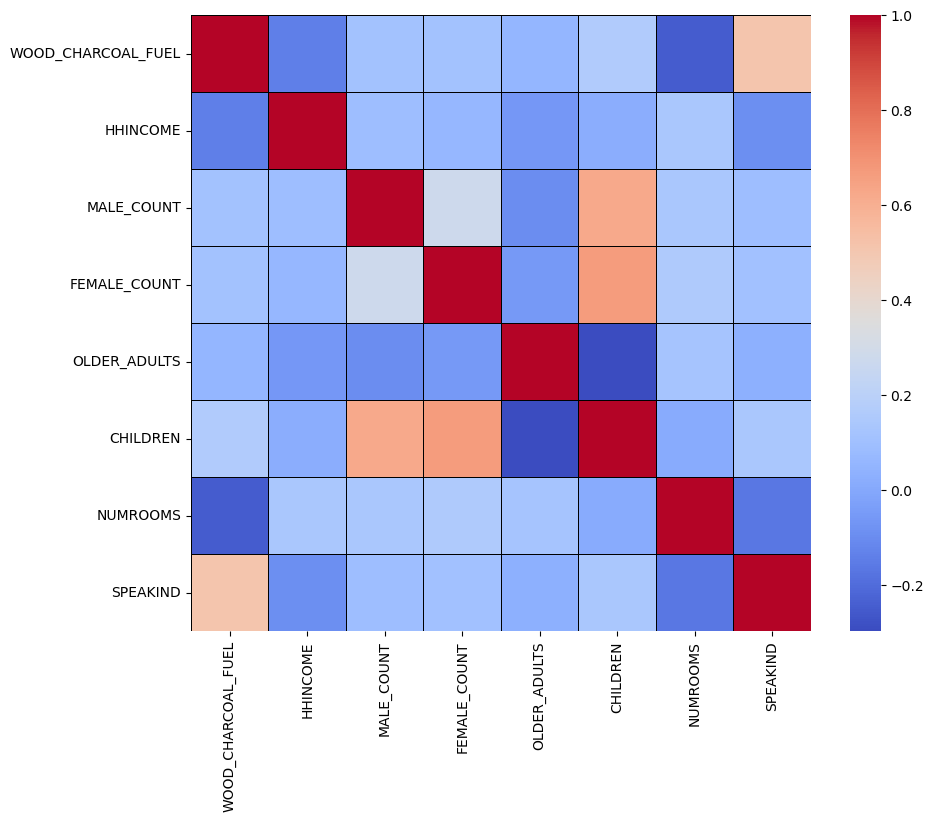

In [66]:
#couple data cuts to see what we expect
corr_variables = ['WOOD_CHARCOAL_FUEL', 'HHINCOME','MALE_COUNT','FEMALE_COUNT','OLDER_ADULTS','CHILDREN','NUMROOMS','SPEAKIND']
corr_data_HH = data_HH_clean[corr_variables].copy()
corr_HH = corr_data_HH.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_HH,annot=False, cmap='coolwarm', linewidths=0.5, linecolor='black',
            xticklabels=corr_HH.columns, yticklabels=corr_HH.columns)
plt.show()

This is about what I expected. Increasing income shows decreasing wood buring fuel use, similar to number of rooms in the house (which is interestingly not very correlated with number of rooms in the house. The number of rooms is also inversely correlated with cooking with wood, even stronger than income (possibly because how much of a house an income can afford varies by region, unless we normalized for average income by region). Also, presence of an indigineous language is correlated with using wood for cooking.

Look into income

Text(0, 0.5, 'Household income')

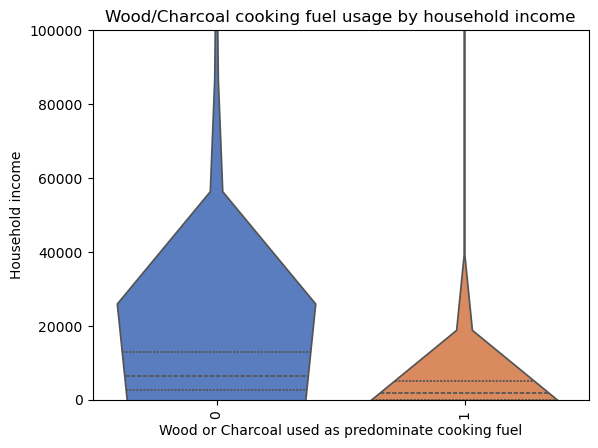

In [106]:
#violin plot to look at income vs. fuel use
sns.violinplot(x = data_HH_clean['WOOD_CHARCOAL_FUEL'], y = data_HH_clean['HHINCOME'], scale = 'count', inner = 'quartile', palette = 'muted')
plt.ylim(0, 100000)
plt.title('Wood/Charcoal cooking fuel usage by household income')
plt.xlabel('Wood or Charcoal used as predominate cooking fuel')
plt.xticks(rotation=90)
plt.ylabel('Household income')

Text(0, 0.5, 'Household income')

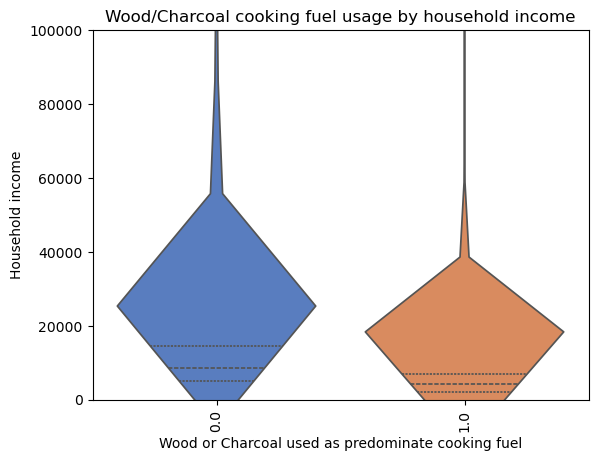

In [104]:
#violin plot to look at income vs. fuel use
data_HH_clean_income = data_HH_clean[data_HH_clean['HHINCOME'] > 0]
sns.violinplot(x = data_HH_clean_income['WOOD_CHARCOAL_FUEL'], y = data_HH_clean['HHINCOME'], scale = 'count', inner = 'quartile', palette = 'muted')
plt.ylim(0, 100000)
plt.title('Wood/Charcoal cooking fuel usage by household income')
plt.xlabel('Wood or Charcoal used as predominate cooking fuel')
plt.xticks(rotation=90)
plt.ylabel('Household income')

Clearly there is an income component to wood burning cooking. However, I need to ensure the 100K+ houses that report no income should be counted as truly having no income

In [98]:
HH_no_income_df = data_HH_clean[data_HH_clean['HHINCOME'] == 0]
HH_no_income_df.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
SERIAL,104330.0,NaN,NaN,NaN,1935160599.300297,1145984057.503101,136000.0,893394500.0,2074025000.0,2840433000.0,4016615000.0
PERSONS,104330.0,NaN,NaN,NaN,3.00139,1.99419,1.0,2.0,2.0,4.0,23.0
HHWT,104330.0,NaN,NaN,NaN,61.503565,118.018612,9.99,9.99,19.98,49.95,3896.1
GEO2_MX,104330.0,2325.0,484009001.0,989.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OWNERSHIP,104330,2,Owned,86812,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ELECTRIC,104330,2,Yes,100325,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WATERSUPPLY,104330,3,"Piped, in home",47408,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SEWAGE,104330,3,Sewage system,46117,NaN,NaN,NaN,NaN,NaN,NaN,NaN
COOKINGFUEL,104330,5,"Wood, charcoal, coal, or other burned biomaterial",53540,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PHONE,104330,2,No,84038,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
for feature in ['OWNERSHIP','ELECTRIC','WATERSUPPLY','SEWAGE','COOKINGFUEL','PHONE','CELL','INTERNET','TRASH','NUMROOMS',
                'KITCHEN','HHTYPE','SPEAKIND','HHINCOME','ANY ILLITERACY','CHILDREN','OLDER_ADULTS','MALE_COUNT','FEMALE_COUNT']:
    print(HH_no_income_df[feature].value_counts())

OWNERSHIP
Owned        86812
Not owned    17518
Name: count, dtype: int64
ELECTRIC
Yes    100325
No       4005
Name: count, dtype: int64
WATERSUPPLY
Piped, in home     47408
Piped access       46094
No piped access    10828
Name: count, dtype: int64
SEWAGE
Sewage system    46117
Septic tank      32894
Not connected    25319
Name: count, dtype: int64
COOKINGFUEL
Wood, charcoal, coal, or other burned biomaterial    53540
Petroleum gas (NG, propane, or other)                47404
None                                                  2802
Electric                                               574
Other (solar, alcohol, etc.)                            10
Name: count, dtype: int64
PHONE
No     84038
Yes    20292
Name: count, dtype: int64
CELL
Yes    58864
No     45466
Name: count, dtype: int64
INTERNET
No     84561
Yes    19769
Name: count, dtype: int64
TRASH
Collected                     57946
Burned, burried, or dumped    46384
Name: count, dtype: int64
NUMROOMS
3.0     29909
2.0     2618

In [102]:
HH_no_income_df_retired = HH_no_income_df[HH_no_income_df['OLDER_ADULTS'] == HH_no_income_df['PERSONS']]
HH_no_income_df_retired

,SERIAL,PERSONS,HHWT,GEO2_MX,OWNERSHIP,ELECTRIC,WATERSUPPLY,SEWAGE,COOKINGFUEL,PHONE,...,NUMFAMILIES,CHILDREN,OLDER_ADULTS,MALE_COUNT,FEMALE_COUNT,SPEAKIND,ANY ILLITERACY,HHINCOME,STATE_NAME,WOOD_CHARCOAL_FUEL
20,206000,1,619.38,484001001,Owned,Yes,"Piped, in home",Sewage system,"Petroleum gas (NG, propane, or other)",Yes,...,1,0,1,0,1,0,0,0.0,Aguascalientes,0
29,296000,1,599.40,484001001,Not owned,Yes,"Piped, in home",Sewage system,"Petroleum gas (NG, propane, or other)",No,...,1,0,1,0,1,0,0,0.0,Aguascalientes,0
37,376000,1,589.41,484001001,Owned,Yes,"Piped, in home",Sewage system,"Petroleum gas (NG, propane, or other)",Yes,...,1,0,1,0,1,0,0,0.0,Aguascalientes,0
46,466000,2,619.38,484001001,Owned,Yes,"Piped, in home",Sewage system,"Petroleum gas (NG, propane, or other)",Yes,...,1,0,2,1,1,0,0,0.0,Aguascalientes,0
47,476000,1,619.38,484001001,Not owned,Yes,"Piped, in home",Sewage system,Electric,Yes,...,1,0,1,0,1,0,0,0.0,Aguascalientes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402051,4016495000,1,9.99,484032004,Owned,Yes,Piped access,Septic tank,"Wood, charcoal, coal, or other burned biomaterial",No,...,1,0,1,0,1,0,1,0.0,Zacatecas,1
402059,4016575000,2,9.99,484032004,Owned,Yes,"Piped, in home",Septic tank,"Wood, charcoal, coal, or other burned biomaterial",No,...,1,0,2,1,1,0,0,0.0,Zacatecas,1
402060,4016585000,2,9.99,484032004,Owned,Yes,"Piped, in home",Not connected,"Petroleum gas (NG, propane, or other)",No,...,1,0,2,1,1,0,0,0.0,Zacatecas,0
402061,4016595000,1,9.99,484032004,Owned,Yes,"Piped, in home",Septic tank,"Wood, charcoal, coal, or other burned biomaterial",No,...,1,0,1,1,0,0,0,0.0,Zacatecas,1


There are 33k households with only people aged 65 and older (retirement age in Mexico) which means these households should be kept at 0, while the others I cannot confirm if 0 income is accurate and will be removed as a comparison.

In [493]:
#Also look at the combination of Kitchen vs. cooking fuel and see if they're correlated, because then can take it out
proportion_kitchen_cookingfuel = data_HH_clean.groupby('KITCHEN')['WOOD_CHARCOAL_FUEL'].value_counts(normalize=True).unstack()
proportion_kitchen_cookingfuel

WOOD_CHARCOAL_FUEL,0,1
KITCHEN,,
Indoor kitchen,0.852539,0.147461
No kitchen,0.797471,0.202529
Outdoor kitchen,0.220541,0.779459


### Modeling

Modeling will start with decision trees to set a baseline, both with and without data where income is 0. From there I will do more decision trees with and without granular geographic data (GEO2_MX). Decision trees are a good baseline because they are less computationally intensive (since we have a large dataset) and will also hopefully be more interpretable. I am using accuracy as a starting point for evaluation metric because in this case there's little risk to not balancing precision vs recall. Having false positives or negatives isn't hugely detrimental, since the goal is to modernize cooking across populations. False negatives are likely worse since you're not attracting a customer that could be switching to a cleaner fuel, vs. false positives where you attempted to switch someones cooking fuel but they were already on gas or electric (the desired outcome). 

In future analysis, I will then perform logistic regression, SVC, and KNN with the higher order Mexico states, vs. more focused regions, as well as more granular data on indigenous speaking populations.

In [771]:
#create dataset with only values needed for decision tree modeling for binary classification
tree_variables = ['PERSONS', #'GEO2_MX',
        'OWNERSHIP', 'ELECTRIC',
       'WATERSUPPLY', 'SEWAGE',
        'KITCHEN','PHONE', 'CELL', 'INTERNET','TRASH', 
        'NUMROOMS', 'HHTYPE', 'NUMFAMILIES', 
        'CHILDREN','OLDER_ADULTS', 'MALE_COUNT', 'FEMALE_COUNT', 
        'SPEAKIND','ANY ILLITERACY','HHINCOME', 
        'STATE_NAME', 'WOOD_CHARCOAL_FUEL']

tree_data_starter = data_HH_clean[tree_variables].copy()

In [772]:
X = tree_data_starter.drop(columns = ['WOOD_CHARCOAL_FUEL'])
y = tree_data_starter['WOOD_CHARCOAL_FUEL']

In [773]:
X = pd.get_dummies(X, drop_first = True)

In [774]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [775]:
#set up tree regression with max_depth of 10 just to start
tree_reg = DecisionTreeClassifier(max_depth = 10)
tree_reg.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10)

In [777]:
#scoring on accuracy
train_acc = tree_reg.score(X_train, y_train)
test_acc = tree_reg.score(X_test, y_test)
depth_1 = tree_reg.get_depth()
print(f'Training Accuracy: {train_acc: .2f}')
print(f'Test Accuracy: {test_acc: .2f}')
print(f'Depth of tree: {depth_1}')

Training Accuracy:  0.88
Test Accuracy:  0.88
Depth of tree: 10


In [781]:
# starter_tree = plot_tree(tree_reg, feature_names = X.columns, filled = True, fontsize=5)
# plt.figure(figsize=(20,20))
# plt.savefig('First_Tree.png')

In [787]:
importances_starter = tree_reg.feature_importances_
feature_importance_tree_starter_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances_starter})
feature_importance_tree_starter_df = feature_importance_tree_starter_df.sort_values(by='importance',ascending=False)
feature_importance_tree_starter_df

,feature,importance
17,KITCHEN_Outdoor kitchen,0.601212
21,TRASH_Collected,0.162974
7,SPEAKIND,0.087190
9,HHINCOME,0.029553
15,SEWAGE_Sewage system,0.022590
20,INTERNET_Yes,0.016076
0,PERSONS,0.013450
19,CELL_Yes,0.012778
13,"WATERSUPPLY_Piped, in home",0.010989
8,ANY ILLITERACY,0.007105


In looking across all features, having an outdoor kitchen is most important for the model, while trash collected, presence of an indigenous speaker in the home, and household income are the top 4 predictors of whether a home uses wood and charcoal as primary cooking fuel. However, this doesn't tell us a very usable story. You'd assume an outdoor kitchen would be wood burning and indoor one gas burning. While we see from the earlier data cut that it's not entirely true but is a good predictor (80% of outdoor kitchens burn wood, but 15% of indoor kitchens do as well)

In [789]:
#Same trees but with no-income removed
tree_data_starter_no_income = tree_data_starter[(tree_data_starter['HHINCOME'] != 0) | (tree_data_starter['PERSONS'] == tree_data_starter['OLDER_ADULTS'])]
tree_data_starter_no_income.info()

<class 'pandas.core.frame.DataFrame'>
Index: 328673 entries, 0 to 402064
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   PERSONS             328673 non-null  int64   
 1   OWNERSHIP           328673 non-null  category
 2   ELECTRIC            328673 non-null  category
 3   WATERSUPPLY         328673 non-null  category
 4   SEWAGE              328673 non-null  category
 5   KITCHEN             328673 non-null  category
 6   PHONE               328673 non-null  category
 7   CELL                328673 non-null  category
 8   INTERNET            328673 non-null  category
 9   TRASH               328673 non-null  object  
 10  NUMROOMS            328673 non-null  float64 
 11  HHTYPE              328673 non-null  category
 12  NUMFAMILIES         328673 non-null  int64   
 13  CHILDREN            328673 non-null  int64   
 14  OLDER_ADULTS        328673 non-null  int64   
 15  MALE_COUNT          32

In [791]:
X_no_inc = tree_data_starter_no_income.drop(columns = ['WOOD_CHARCOAL_FUEL'])
y_no_inc = tree_data_starter_no_income['WOOD_CHARCOAL_FUEL']

In [793]:
X_no_inc = pd.get_dummies(X_no_inc, drop_first = True)

In [795]:
X_train_ni, X_test_ni, y_train_ni, y_test_ni = train_test_split(X_no_inc, y_no_inc, test_size = 0.2)

In [796]:
#set up tree regression with max_depth of 10 just to start
tree_reg_ni = DecisionTreeClassifier(max_depth = 10)
tree_reg_ni.fit(X_train_ni, y_train_ni)

DecisionTreeClassifier(max_depth=10)

In [798]:
#scoring on accuracy
train_acc_ni = tree_reg_ni.score(X_train_ni, y_train_ni)
test_acc_ni = tree_reg_ni.score(X_test_ni, y_test_ni)
depth_1_ni = tree_reg_ni.get_depth()
print(f'Training Accuracy: {train_acc_ni: .2f}')
print(f'Test Accuracy: {test_acc_ni: .2f}')
print(f'Depth of tree: {depth_1_ni}')

Training Accuracy:  0.88
Test Accuracy:  0.88
Depth of tree: 10


In [801]:
importances_starter_ni = tree_reg_ni.feature_importances_
feature_importance_tree_starter_ni_df = pd.DataFrame({'feature': X_train_ni.columns, 'importance': importances_starter_ni})
feature_importance_tree_starter_ni_df = feature_importance_tree_starter_ni_df.sort_values(by='importance',ascending=False)
feature_importance_tree_starter_ni_df

,feature,importance
17,KITCHEN_Outdoor kitchen,0.596565
21,TRASH_Collected,0.148086
7,SPEAKIND,0.090116
9,HHINCOME,0.029485
15,SEWAGE_Sewage system,0.026335
20,INTERNET_Yes,0.017834
19,CELL_Yes,0.016157
0,PERSONS,0.013252
13,"WATERSUPPLY_Piped, in home",0.012866
8,ANY ILLITERACY,0.008318


When we remove the households that don't have a clear reason for having $0 income (and can therefore assume a mistake in the census process or an unwillingness to answer), given I don't have a reliable proxy for income, the models surprisingly results in nearly the exact same accuracy and feature importance. I'm not yet sure how to explain this other than income doesn't have much of an impact on prediction results and therefore doesn't sway much when the 70K+ households are removed from the analysis. 

In [803]:
#now look at the same thing where kitchen is indoor only
tree_data_starter_indoor = tree_data_starter[tree_data_starter['KITCHEN'] == 'Indoor kitchen']
tree_data_starter_indoor.info()

<class 'pandas.core.frame.DataFrame'>
Index: 273211 entries, 0 to 402063
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   PERSONS             273211 non-null  int64   
 1   OWNERSHIP           273211 non-null  category
 2   ELECTRIC            273211 non-null  category
 3   WATERSUPPLY         273211 non-null  category
 4   SEWAGE              273211 non-null  category
 5   KITCHEN             273211 non-null  category
 6   PHONE               273211 non-null  category
 7   CELL                273211 non-null  category
 8   INTERNET            273211 non-null  category
 9   TRASH               273211 non-null  object  
 10  NUMROOMS            273211 non-null  float64 
 11  HHTYPE              273211 non-null  category
 12  NUMFAMILIES         273211 non-null  int64   
 13  CHILDREN            273211 non-null  int64   
 14  OLDER_ADULTS        273211 non-null  int64   
 15  MALE_COUNT          27

In [805]:
X_indoor = tree_data_starter_indoor.drop(columns = ['WOOD_CHARCOAL_FUEL'])
y_indoor = tree_data_starter_indoor['WOOD_CHARCOAL_FUEL']
X_indoor = pd.get_dummies(X_indoor, drop_first = True)
X_train_indoor, X_test_indoor, y_train_indoor, y_test_indoor = train_test_split(X_indoor, y_indoor, test_size = 0.2)

In [813]:
tree_indoor = DecisionTreeClassifier(max_depth = 10)
tree_indoor.fit(X_train_indoor, y_train_indoor)

DecisionTreeClassifier(max_depth=10)

In [814]:
#scoring on accuracy
train_acc_indoor = tree_indoor.score(X_train_indoor, y_train_indoor)
test_acc_indoor = tree_indoor.score(X_test_indoor, y_test_indoor)
depth_1_indoor = tree_indoor.get_depth()
print(f'Training Accuracy: {train_acc_indoor: .2f}')
print(f'Test Accuracy: {test_acc_indoor: .2f}')
print(f'Depth of tree: {depth_1_indoor}')

Training Accuracy:  0.90
Test Accuracy:  0.90
Depth of tree: 10


In [815]:
importances_starter_indoor = tree_indoor.feature_importances_
feature_importance_tree_starter_indoor_df = pd.DataFrame({'feature': X_train_indoor.columns, 'importance': importances_starter_indoor})
feature_importance_tree_starter_indoor_df = feature_importance_tree_starter_indoor_df.sort_values(by='importance',ascending=False)
feature_importance_tree_starter_indoor_df

,feature,importance
21,TRASH_Collected,0.421669
7,SPEAKIND,0.217901
9,HHINCOME,0.081088
19,CELL_Yes,0.048278
13,"WATERSUPPLY_Piped, in home",0.038398
0,PERSONS,0.033068
20,INTERNET_Yes,0.026136
15,SEWAGE_Sewage system,0.025627
8,ANY ILLITERACY,0.019861
34,STATE_NAME_Chiapas,0.010082


Finally, it is worth looking at indoor kitchens because there are particular health risks in indoor wood burning kitchens. Looking just as homes with indoor kitchens, there's even more accuracy in the decision tree model (90%) while also highlighting the importance of being on public services (trash collection, water supply) is to not using wood burning fuel. Additionally, speaking an indigineous language again shows up as the most impotant demographic feature, followed by household income. This is interesting as there is both a geographic and cultural component to wood burning cooking, and needs to be explored in more detail. 

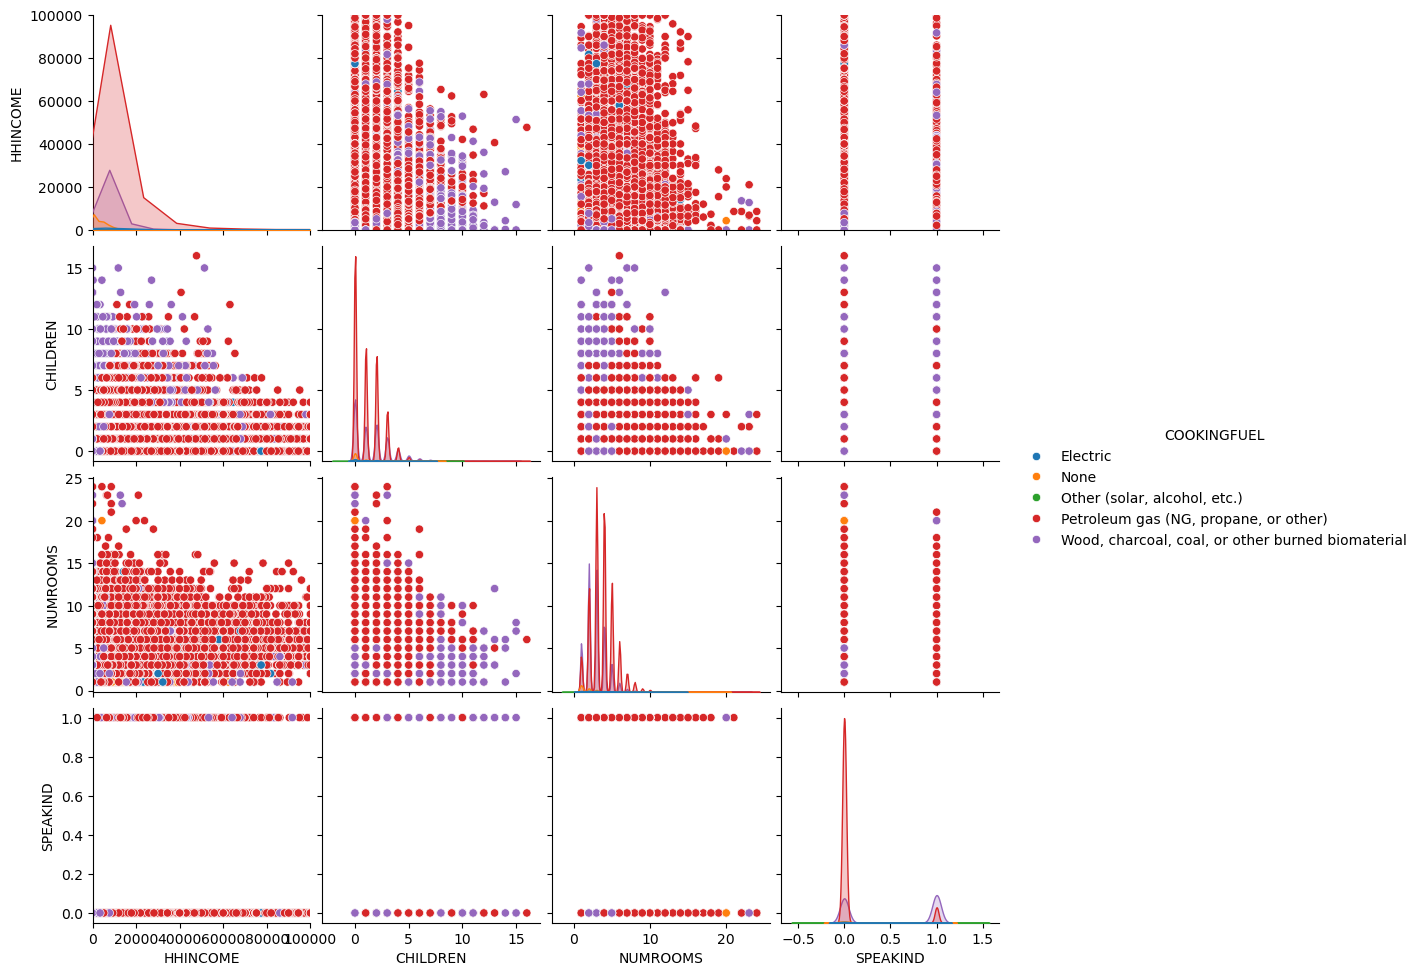

In [158]:
pairplot_variables = ['COOKINGFUEL', 'HHINCOME','CHILDREN','NUMROOMS','SPEAKIND']
data_HH_clean_pairplot = data_HH_clean[pairplot_variables].copy()
plot = sns.pairplot(data = data_HH_clean_pairplot, hue = 'COOKINGFUEL')
for ax in plot.axes.flat:
    if ax.get_ylabel() == 'HHINCOME':
        ax.set_ylim(0,100000)
    if ax.get_xlabel() == 'HHINCOME':
        ax.set_xlim(0,100000)

plt.show()